**Navdeep Singh Bedi**

In [12]:
!rm -r AI2022MA/
!git clone https://github.com/UmbertoJr/AI2022MA.git &> /dev/null

rm: cannot remove 'AI2022MA/': No such file or directory


In [13]:
import random

name: eil76
nPoints: 76
best_sol: 538.0


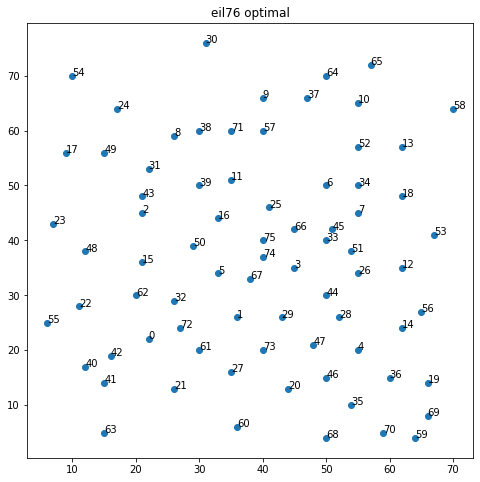

In [14]:
# Imports

from AI2022MA.IO_manager.io_tsp import TSP_Instance_Creator
# if you are running from your local remove the prefix AI2020 (comment the previous line and uncomment the following line)
# from IO_manager.io_tsp import TSP_Instance_Creator

ic = TSP_Instance_Creator("standard", 'eil76.tsp')
ic.print_info()
ic.plot_data()

name: ch130
nPoints: 130
best_sol: 6110.0


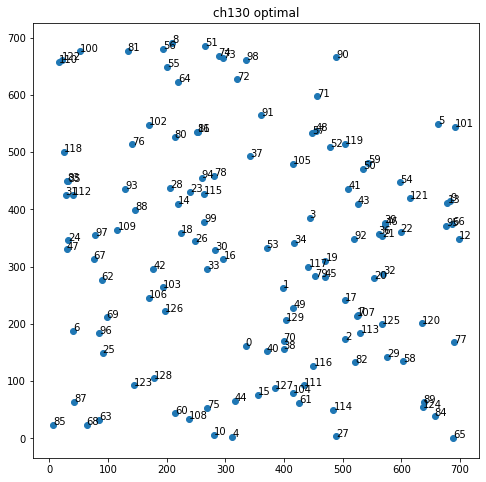

In [15]:
ic = TSP_Instance_Creator("standard", 'ch130.tsp')
ic.print_info()
ic.plot_data()

name: d198
nPoints: 198
best_sol: 15780.0


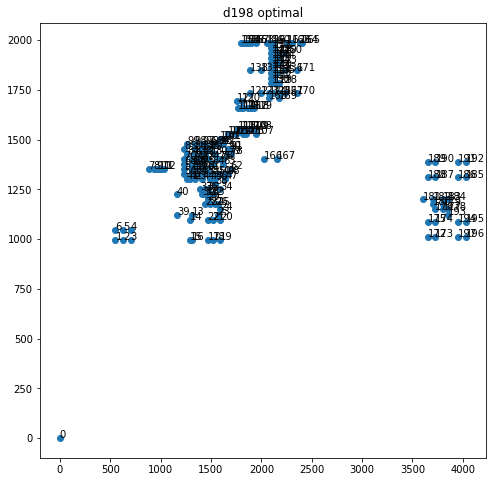

In [16]:
ic = TSP_Instance_Creator("standard", 'd198.tsp')
ic.print_info()
ic.plot_data()

name: myTSP_dim10
nPoints: 10
best_sol: 2732.0


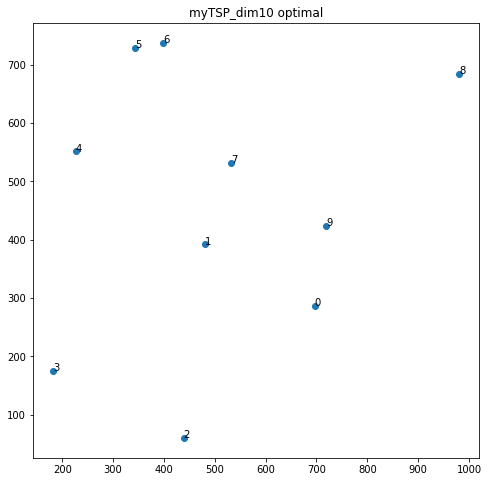

In [17]:
ic = TSP_Instance_Creator("standard", 'myTSP_dim10.tsp')
ic.print_info()
ic.plot_data()

In [18]:
import numpy as np
from AI2022MA.solvers.local_search import twoOpt
from AI2022MA.solvers.constructive_algorithms import nn
from AI2022MA.solvers.two_opt_with_candidate import twoOpt_with_cl

In [19]:
import time

Below I implement ACS.

There is an ACS class with number of ants: m = 10, the power to which the pheomone η is raised during the selection of the next city: β = 2, the pheromone decay parameters during the local and the global update: ρ and α = 0.1 and the lenght of candidate list which is a dictionary containing the list of all the nodes (cities) as keys and the value of each key refering to the cities closest to the respective city represented by the list of values is: cl = 15. 

Next the variables of the class are initialized.

Then I implement the initialization method in which I randomly assign the initial position to all the 10 ants and also assign the list of available cities for each ant, the tour list of each ant and the length of the tour of each ant as a dictionary.

Next, I implement the tour building method. It contains three loops. The innermost loop iterated through each ant and choose the next city for each ant by the rules given below:

1) If the value of q drawn from the random distribution is less than or equal to the parameter q_0:

Then I check how much candidate list is present inside the tour list of each ant. If none of the city of the candidate list is present in the tour list than I choose the city of the candidate list with the highest value of τ*(η^2) as the next city for the particular ant. 

If the cities in the candidate list of the position of a particular and is partially in the tour list of that particular ant then I take the rest of the cities in the candidate list of the position of that particular ant and choose the next city with the same rule as mentioned in the previous point. 

If the all cities in the candidate list is present in the tour of the particular ant then I take the rest available cities of the particular ant which have not been visited previously by the ant and choose from the same rule as above the next city. 

2) If the value of q drawn from the random distribution is greater that q_0:

Then if the tour of the ant does not contain any city from the candidate list of the present city of the particular ant then I choose the city from the candidate list with the probability p = τ*(η^2)/Σ(τ*(η^2)).

If the cities in the candidate list of the position of a particular ant is partially in the tour list of that particular ant then I take the rest of the cities in the candidate list of the position of that particular ant and choose the next city with the same probability rule as mentioned in the previous point. 
 
If the all cities in the candidate list is present in the tour of the particular ant then I take the rest available cities of the particular ant which have not been visited previously by the ant and choose from the same probability rule as above the next city. 

Once I have choosed the next city I append it to the tour list of the ant and remove it from the list of available cities for that particular ant. 

Then I apply the local update rule for the pheromone given in the paper.
This is done for each ant until the tour of the tour is completed. As the tour completes I add the first city of every ant to the end of the tour list of the ants and apply the local update rule there as well. 

Then, there comes the second loop which is to build the tour of the ants which iterate over the total number of nodes or cities in the instance.
After, I have the complete full tour of each ant I find the best tour out of it and if the variant is 'ACS+2opt' then I apply '2opt' to the best solution and get the new tour and the new length.

Next, I apply the global updating rule for the pheromone for the each city in the tour list of every ant as follows:


1) The path between the cities of the ants with not the best tour get partially evaporated by the formula given in the paper.


2) The path between the cities in the tour list of ant with the best tour gets an extra term to increase its pheromone value to make the path more favourable for other ants to follow, along with the evaporation term which decrease the pheromone value along the path.

Then comes the outermost loop which runs the inner iterations for 3 min (in our case).

Then, I finally collect the values of the the best tour, best gap, best gap per iteration, best gap % for each variant, instance, q_0 and seed.

In [ ]:
import numpy as np
from AI2022MA.solvers.local_search import twoOpt
from AI2022MA.solvers.constructive_algorithms import nn

# nn takes as input the distance matrix and returns 
# the tour and the length constructed with nearest neighbor, i.e.   tour, len_t = nn(dist_mat)

# twoOpt takes as input the solution, the actual_len and the distance matrix 
# and returns the tour and the length created with 2-opt, i.e.     tour, lent_t = twoOpt(solution, actual_len, dist_mat)

class ACS:
  m = 10
  beta = 2
  alpha = rho = 0.1
  cl = 15
  # q_0 = 0.98


  def __init__(self, variant, instance, q_0, seed):
    self.inst = instance
    self.n = instance.nPoints
    self.dist_mat = instance.dist_matrix
    _, self.L_nn = nn(instance.dist_matrix, starting_node=np.random.choice(self.n))
    self.tau0 = 1./(float(self.n) * self.L_nn)
    self.position = {i: None for i in range(ACS.m)}  # position collector for the Ants, TO BE UPDATED during the steps 
    self.tour = {i: [] for i in range(ACS.m)}  # tour collector for the Ants 
    self.pheromone = {r: [self.tau0]*self.n for r in range(self.n)}
    self.candidate_list = {r: ACS.take_candidates(r, instance.dist_matrix) for r in range(self.n)}
    self.eta = {r: [1/self.dist_mat[r, s] if self.dist_mat[r, s] > 0 else 0 for s in [o for o in range(self.n)]] for r in range(self.n)}
    self.variant = variant
    self.q_0 = q_0
    self.seed = seed
    self.best_solution = instance.best_sol
    self.L_min = []
    self.gap = []
    # self.iter = []
  
  @staticmethod

  def take_candidates(j, dist_mat):
    return list(np.argsort(dist_mat[j])[1:ACS.cl+1])

  def initialization(self):
    self.initital_position = np.random.choice(range(self.n), size=ACS.m, replace=False)
    self.position = {i: self.initital_position[i] for i in range(ACS.m)} #assigning the position to each ant
    
    city_list = list(range(self.n)) #list of all cities
    self.available_cities = {i: city_list[:self.position[i]] + city_list[self.position[i]+1:] for i in range(ACS.m)} #dictionary of list of all cities available for each ant to visit
    
    self.tour = {i: [self.position[i]] for i in range(ACS.m)}
    self.tour_length = {i: 0 for i in range(ACS.m)}

  def tour_building(self):

    initial_time = time.time()
    # w = 0
    while time.time() - initial_time < 180:
      self.initialization()

      for j in range(self.n):

        if j < self.n - 1:
          for i in range(ACS.m):
            
            self.q = np.random.random()
            
            if self.q <= self.q_0 and len(list(set(self.candidate_list[self.position[i]]) & set(self.tour[i]))) == 0 and len(self.available_cities[i]) != 0:
              s = self.candidate_list[self.position[i]][np.argmax((np.array([self.pheromone[self.position[i]][candidate] for candidate in self.candidate_list[self.position[i]]]))*(np.array([self.eta[self.position[i]][candidate] for candidate in self.candidate_list[self.position[i]]]))**2)]

            elif self.q > self.q_0 and len(list(set(self.candidate_list[self.position[i]]) & set(self.tour[i]))) == 0 and len(self.available_cities[i]) != 0:
              probability = ((np.array([self.pheromone[self.position[i]][candidate] for candidate in self.candidate_list[self.position[i]]]))*(np.array([self.eta[self.position[i]][candidate] for candidate in self.candidate_list[self.position[i]]]))**2)/np.sum(((np.array([self.pheromone[self.position[i]][candidate] for candidate in self.candidate_list[self.position[i]]]))*(np.array([self.eta[self.position[i]][candidate] for candidate in self.candidate_list[self.position[i]]]))**2))
              s = np.random.choice(self.candidate_list[self.position[i]], 1, p=probability).item()
            
            elif self.q <= self.q_0 and len(list(set(self.candidate_list[self.position[i]]) & set(self.tour[i]))) < len(list(set(self.candidate_list[self.position[i]]))) and len(self.available_cities[i]) != 0:
              candidate_without_tour_list = list(set(self.candidate_list[self.position[i]]).difference(set(self.tour[i])))
              s = candidate_without_tour_list[np.argmax((np.array([self.pheromone[self.position[i]][candidate] for candidate in candidate_without_tour_list]))*(np.array([self.eta[self.position[i]][candidate] for candidate in candidate_without_tour_list]))**2)]

            elif self.q > self.q_0 and len(list(set(self.candidate_list[self.position[i]]) & set(self.tour[i]))) < len(list(set(self.candidate_list[self.position[i]]))) and len(self.available_cities[i]) != 0:
              candidate_without_tour_list = list(set(self.candidate_list[self.position[i]]).difference(set(self.tour[i])))
              probability = ((np.array([self.pheromone[self.position[i]][candidate] for candidate in candidate_without_tour_list]))*(np.array([self.eta[self.position[i]][candidate] for candidate in candidate_without_tour_list]))**2)/np.sum(((np.array([self.pheromone[self.position[i]][candidate] for candidate in candidate_without_tour_list]))*(np.array([self.eta[self.position[i]][candidate] for candidate in candidate_without_tour_list]))**2))
              s = np.random.choice(candidate_without_tour_list, 1, p=probability).item()


            elif self.q <= self.q_0 and len(list(set(self.candidate_list[self.position[i]]) & set(self.tour[i]))) == len(list(set(self.candidate_list[self.position[i]]))) and len(self.available_cities[i]) != 0:
              all_other_cities = list(set(self.available_cities[i]).difference(set(self.tour[i])))
              s = all_other_cities[np.argmax((np.array([self.pheromone[self.position[i]][candidate] for candidate in all_other_cities]))*(np.array([self.eta[self.position[i]][candidate] for candidate in all_other_cities]))**2)]

            elif self.q > self.q_0 and len(list(set(self.candidate_list[self.position[i]]) & set(self.tour[i]))) == len(list(set(self.candidate_list[self.position[i]]))) and len(self.available_cities[i]) != 0 :
              all_other_cities = list(set(self.available_cities[i]).difference(set(self.tour[i])))
              probability = ((np.array([self.pheromone[self.position[i]][candidate] for candidate in all_other_cities]))*(np.array([self.eta[self.position[i]][candidate] for candidate in all_other_cities]))**2)/np.sum(((np.array([self.pheromone[self.position[i]][candidate] for candidate in all_other_cities]))*(np.array([self.eta[self.position[i]][candidate] for candidate in all_other_cities]))**2))
              s = np.random.choice(all_other_cities, 1, p=probability).item()

            self.available_cities[i].remove(s)
            self.tour[i].append(s)
            
            self.pheromone[self.position[i]][s] = (1 - ACS.rho)*self.pheromone[self.position[i]][s] + ACS.rho*self.tau0
            self.position[i] = s
            
        elif len(self.available_cities[i]) == 0 and j == self.n - 1:
          for i in range(ACS.m):
            s = self.tour[i][0]
            self.tour[i].append(s)
            
            self.pheromone[self.position[i]][s] = (1 - ACS.rho)*self.pheromone[self.position[i]][s] + ACS.rho*self.tau0
            self.position[i] = s
       

      for i in range(ACS.m):
        self.tour_length[i] = sum([self.dist_mat[self.tour[i][e]][self.tour[i][e+1]] for e in range(len(self.tour[i])-1)])
      L_best_key = min(self.tour_length, key=self.tour_length.get)

      if self.variant == 'ACS+2opt':
        self.tour[L_best_key], self.tour_length[L_best_key] = twoOpt_with_cl(self.tour[L_best_key], self.tour_length[L_best_key], self.dist_mat, self.candidate_list)
        self.tour_length[L_best_key] = self.tour_length[L_best_key].item()

      
      L_best = self.tour_length[L_best_key]
      self.L_min.append(L_best)
      gap_ = L_best - self.best_solution
      self.gap.append(gap_)
      # w = w + j
      # self.iter.append(w)


      for i in range(ACS.m):
        if i == L_best_key:
          for idx in range(len(self.tour[i])-1):
            self.pheromone[self.tour[i][idx]][self.tour[i][idx+1]] = (1 - ACS.alpha)*self.pheromone[self.tour[i][idx]][self.tour[i][idx+1]] + ACS.alpha*(1/L_best)
        else:
          for idx in range(len(self.tour[i])-1):
            self.pheromone[self.tour[i][idx]][self.tour[i][idx+1]] = (1 - ACS.alpha)*self.pheromone[self.tour[i][idx]][self.tour[i][idx+1]]
    

    print(f' Variant: {self.variant},  Instance: {self.inst.name}, q_0: {self.q_0}, Random Seed: {self.seed}, Best_length: {min(self.L_min)}, Best_sol: {self.best_solution}, Best_gap: {min(self.L_min)-self.best_solution}, Best_gap_%: {((min(self.L_min)-self.best_solution)*100)/self.best_solution}')    
    print(f'number_of_tours_generated_for_best_tour: {self.L_min.index(min(self.L_min))}')
    return min(self.L_min), self.best_solution, min(self.L_min)-self.best_solution, ((min(self.L_min)-self.best_solution)*100)/self.best_solution, self.L_min.index(min(self.L_min)), self.gap
    

In [4]:
import matplotlib.pyplot as plt

In [3]:
import json

In [ ]:
variants = ['ACS', 'ACS+2opt']
instances = [TSP_Instance_Creator("standard", 'eil76.tsp'), TSP_Instance_Creator("standard", 'ch130.tsp'), TSP_Instance_Creator("standard", 'd198.tsp')]
seeds = [0, 42, 123]
result_dictionary = {}
i = 0
gap_list = []
# iter_list = []
for variant in variants:
  for instance in instances:
    q_0 = [0.5, 0.98, round((1 - 13/instance.nPoints),2)]
    for q_ in q_0:
      for seed in seeds:
        np.random.seed(seed)
        acs = ACS(variant, instance, q_, seed)
        min_len, best_sol, best_gap, relative_err, num_of_tours_to_best, gap = acs.tour_building()
        result_dictionary[i] = [variant, instance.name, q_, seed, min_len, best_sol, best_gap, relative_err, num_of_tours_to_best]
        i += 1
        gap_list.append(gap)
        # iter_list.append(iter)    
  
with open('result_dictionary.txt', 'w') as convert_file:
     convert_file.write(json.dumps(result_dictionary))

with open('gap_list.txt', 'w') as convert_file:
     convert_file.write(json.dumps(gap_list))

# with open('iter_list.txt', 'w') as convert_file:
#      convert_file.write(json.dumps(iter_list))



 Variant: ACS,  Instance: eil76, q_0: 0.5, Random Seed: 0, Best_length: 638.0, Best_sol: 538.0, Best_gap: 100.0, Best_gap_%: 18.587360594795538
number_of_tours_generated_for_best_tour: 2491
 Variant: ACS,  Instance: eil76, q_0: 0.5, Random Seed: 42, Best_length: 654.0, Best_sol: 538.0, Best_gap: 116.0, Best_gap_%: 21.561338289962826
number_of_tours_generated_for_best_tour: 3168
 Variant: ACS,  Instance: eil76, q_0: 0.5, Random Seed: 123, Best_length: 664.0, Best_sol: 538.0, Best_gap: 126.0, Best_gap_%: 23.42007434944238
number_of_tours_generated_for_best_tour: 3297
 Variant: ACS,  Instance: eil76, q_0: 0.98, Random Seed: 0, Best_length: 541.0, Best_sol: 538.0, Best_gap: 3.0, Best_gap_%: 0.5576208178438662
number_of_tours_generated_for_best_tour: 3607
 Variant: ACS,  Instance: eil76, q_0: 0.98, Random Seed: 42, Best_length: 544.0, Best_sol: 538.0, Best_gap: 6.0, Best_gap_%: 1.1152416356877324
number_of_tours_generated_for_best_tour: 1731
 Variant: ACS,  Instance: eil76, q_0: 0.98, Rando

In [2]:
import statistics

In [ ]:
with open('result_dictionary.txt') as f:
    data = f.read()

js = json.loads(data)

In [ ]:
result_dictionary = {int(k):v for k,v in js.items()}


In [ ]:
result_dictionary

{0: ['ACS', 'eil76', 0.5, 0, 638.0, 538.0, 100.0, 18.587360594795538, 2491],
 1: ['ACS', 'eil76', 0.5, 42, 654.0, 538.0, 116.0, 21.561338289962826, 3168],
 2: ['ACS', 'eil76', 0.5, 123, 664.0, 538.0, 126.0, 23.42007434944238, 3297],
 3: ['ACS', 'eil76', 0.98, 0, 541.0, 538.0, 3.0, 0.5576208178438662, 3607],
 4: ['ACS', 'eil76', 0.98, 42, 544.0, 538.0, 6.0, 1.1152416356877324, 1731],
 5: ['ACS', 'eil76', 0.98, 123, 553.0, 538.0, 15.0, 2.7881040892193307, 4847],
 6: ['ACS', 'eil76', 0.83, 0, 586.0, 538.0, 48.0, 8.921933085501859, 342],
 7: ['ACS', 'eil76', 0.83, 42, 594.0, 538.0, 56.0, 10.408921933085502, 618],
 8: ['ACS', 'eil76', 0.83, 123, 595.0, 538.0, 57.0, 10.594795539033457, 4456],
 9: ['ACS', 'ch130', 0.5, 0, 7776.0, 6110.0, 1666.0, 27.266775777414075, 1],
 10: ['ACS',
  'ch130',
  0.5,
  42,
  7837.0,
  6110.0,
  1727.0,
  28.265139116202946,
  311],
 11: ['ACS',
  'ch130',
  0.5,
  123,
  7874.0,
  6110.0,
  1764.0,
  28.870703764320787,
  959],
 12: ['ACS', 'ch130', 0.98, 0, 6

In [ ]:
frame = []

In [ ]:
dict_min_len_ACS_eil76_0 = {}
dict_min_len_ACS_eil76_42 = {}
dict_min_len_ACS_eil76_123 = {}



for k in result_dictionary.keys():
  if result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'eil76' and result_dictionary[k][2] == 0.5:
    dict_min_len_ACS_eil76_0[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'eil76' and result_dictionary[k][2] == 0.98:
    dict_min_len_ACS_eil76_42[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'eil76' and result_dictionary[k][2] == 0.83:
    dict_min_len_ACS_eil76_123[k] = result_dictionary[k][4]

min_len_ACS_eil76_0 = min(dict_min_len_ACS_eil76_0.values())
min_len_ACS_eil76_42 = min(dict_min_len_ACS_eil76_42.values())
min_len_ACS_eil76_123 = min(dict_min_len_ACS_eil76_123.values())

avg_len_ACS_eil76_0 = statistics.mean(dict_min_len_ACS_eil76_0.values())
avg_len_ACS_eil76_42 = statistics.mean(dict_min_len_ACS_eil76_42.values())
avg_len_ACS_eil76_123 = statistics.mean(dict_min_len_ACS_eil76_123.values())

std_len_ACS_eil76_0 = statistics.stdev(dict_min_len_ACS_eil76_0.values())
std_len_ACS_eil76_42 = statistics.stdev(dict_min_len_ACS_eil76_42.values())
std_len_ACS_eil76_123 = statistics.stdev(dict_min_len_ACS_eil76_123.values())


print('min_len_ACS_eil76_0:', min_len_ACS_eil76_0)
print('min_len_ACS_eil76_42:', min_len_ACS_eil76_42)
print('min_len_ACS_eil76_123:', min_len_ACS_eil76_123)

print('avg_len_ACS_eil76_0:', round((avg_len_ACS_eil76_0), 0))
print('avg_len_ACS_eil76_42:', round((avg_len_ACS_eil76_42), 0))
print('avg_len_ACS_eil76_123:', round((avg_len_ACS_eil76_123), 0))

print('std_len_ACS_eil76_0:', round((std_len_ACS_eil76_0), 0))
print('std_len_ACS_eil76_42:', round((std_len_ACS_eil76_42), 0))
print('std_len_ACS_eil76_123:', round((std_len_ACS_eil76_123), 0))

best_sol_ACS_eil76 = result_dictionary[list(dict_min_len_ACS_eil76_0.keys())[list(dict_min_len_ACS_eil76_0.values()).index(min_len_ACS_eil76_0)]][5]

print('best_sol_eil76', best_sol_ACS_eil76)

relative_error_ACS_eil76_0 = result_dictionary[list(dict_min_len_ACS_eil76_0.keys())[list(dict_min_len_ACS_eil76_0.values()).index(min_len_ACS_eil76_0)]][7]
relative_error_ACS_eil76_42 = result_dictionary[list(dict_min_len_ACS_eil76_42.keys())[list(dict_min_len_ACS_eil76_42.values()).index(min_len_ACS_eil76_42)]][7]
relative_error_ACS_eil76_123 = result_dictionary[list(dict_min_len_ACS_eil76_123.keys())[list(dict_min_len_ACS_eil76_123.values()).index(min_len_ACS_eil76_123)]][7]

print('relative_error_ACS_eil76_0:', round((relative_error_ACS_eil76_0), 2))
print('relative_error_ACS_eil76_42:', round((relative_error_ACS_eil76_42), 2))
print('relative_error_ACS_eil76_123:', round((relative_error_ACS_eil76_123), 2))

tours_for_the_best_ACS_eil76_0 = result_dictionary[list(dict_min_len_ACS_eil76_0.keys())[list(dict_min_len_ACS_eil76_0.values()).index(min_len_ACS_eil76_0)]][8]
tours_for_the_best_ACS_eil76_42 = result_dictionary[list(dict_min_len_ACS_eil76_42.keys())[list(dict_min_len_ACS_eil76_42.values()).index(min_len_ACS_eil76_42)]][8]
tours_for_the_best_ACS_eil76_123 = result_dictionary[list(dict_min_len_ACS_eil76_123.keys())[list(dict_min_len_ACS_eil76_123.values()).index(min_len_ACS_eil76_123)]][8]

print('tours_for_the_best_ACS_eil76_0:', tours_for_the_best_ACS_eil76_0)
print('tours_for_the_best_ACS_eil76_42:', tours_for_the_best_ACS_eil76_42)
print('tours_for_the_best_ACS_eil76_123:', tours_for_the_best_ACS_eil76_123)

ACS_eil76_0 = ['ACS', 'eil76', '0.5', min_len_ACS_eil76_0, tours_for_the_best_ACS_eil76_0, round((avg_len_ACS_eil76_0), 0), round((std_len_ACS_eil76_0), 0), best_sol_ACS_eil76, round((relative_error_ACS_eil76_0), 2)]
ACS_eil76_42 = ['ACS', 'eil76', '0.98', min_len_ACS_eil76_42, tours_for_the_best_ACS_eil76_42, round((avg_len_ACS_eil76_42), 0), round((std_len_ACS_eil76_42), 0), best_sol_ACS_eil76, round((relative_error_ACS_eil76_42), 2)]
ACS_eil76_123 = ['ACS', 'eil76', '0.83', min_len_ACS_eil76_123, tours_for_the_best_ACS_eil76_123, round((avg_len_ACS_eil76_123), 0), round((std_len_ACS_eil76_123), 0), best_sol_ACS_eil76, round((relative_error_ACS_eil76_123), 2)]

frame.append(ACS_eil76_0)
frame.append(ACS_eil76_42)
frame.append(ACS_eil76_123)

min_len_ACS_eil76_0: 638.0
min_len_ACS_eil76_42: 541.0
min_len_ACS_eil76_123: 586.0
avg_len_ACS_eil76_0: 652.0
avg_len_ACS_eil76_42: 546.0
avg_len_ACS_eil76_123: 592.0
std_len_ACS_eil76_0: 13.0
std_len_ACS_eil76_42: 6.0
std_len_ACS_eil76_123: 5.0
best_sol_eil76 538.0
relative_error_ACS_eil76_0: 18.59
relative_error_ACS_eil76_42: 0.56
relative_error_ACS_eil76_123: 8.92
tours_for_the_best_ACS_eil76_0: 2491
tours_for_the_best_ACS_eil76_42: 3607
tours_for_the_best_ACS_eil76_123: 342


In [ ]:
dict_min_len_ACS_ch130_0 = {}
dict_min_len_ACS_ch130_42 = {}
dict_min_len_ACS_ch130_123 = {}


for k in result_dictionary.keys():
  if result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'ch130' and result_dictionary[k][2] == 0.5:
    dict_min_len_ACS_ch130_0[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'ch130' and result_dictionary[k][2] == 0.98:
    dict_min_len_ACS_ch130_42[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'ch130' and result_dictionary[k][2] == 0.9:
    dict_min_len_ACS_ch130_123[k] = result_dictionary[k][4]


min_len_ACS_ch130_0 = min(dict_min_len_ACS_ch130_0.values())
min_len_ACS_ch130_42 = min(dict_min_len_ACS_ch130_42.values())
min_len_ACS_ch130_123 = min(dict_min_len_ACS_ch130_123.values())

avg_len_ACS_ch130_0 = statistics.mean(dict_min_len_ACS_ch130_0.values())
avg_len_ACS_ch130_42 = statistics.mean(dict_min_len_ACS_ch130_42.values())
avg_len_ACS_ch130_123 = statistics.mean(dict_min_len_ACS_ch130_123.values())

std_len_ACS_ch130_0 = statistics.stdev(dict_min_len_ACS_ch130_0.values())
std_len_ACS_ch130_42 = statistics.stdev(dict_min_len_ACS_ch130_42.values())
std_len_ACS_ch130_123 = statistics.stdev(dict_min_len_ACS_ch130_123.values())


print('min_len_ACS_ch130_0:', min_len_ACS_ch130_0)
print('min_len_ACS_ch130_42:', min_len_ACS_ch130_42)
print('min_len_ACS_ch130_123:', min_len_ACS_ch130_123)

print('avg_len_ACS_ch130_0:', round((avg_len_ACS_ch130_0), 0))
print('avg_len_ACS_ch130_42:', round((avg_len_ACS_ch130_42), 0))
print('avg_len_ACS_ch130_123:', round((avg_len_ACS_ch130_123), 0))

print('std_len_ACS_ch130_0:', round((std_len_ACS_ch130_0), 0))
print('std_len_ACS_ch130_42:', round((std_len_ACS_ch130_42), 0))
print('std_len_ACS_ch130_123:', round((std_len_ACS_ch130_123), 0))

best_sol_ACS_ch130 = result_dictionary[list(dict_min_len_ACS_ch130_0.keys())[list(dict_min_len_ACS_ch130_0.values()).index(min_len_ACS_ch130_0)]][5]

print('best_sol_ch130', best_sol_ACS_ch130)

relative_error_ACS_ch130_0 = result_dictionary[list(dict_min_len_ACS_ch130_0.keys())[list(dict_min_len_ACS_ch130_0.values()).index(min_len_ACS_ch130_0)]][7]
relative_error_ACS_ch130_42 = result_dictionary[list(dict_min_len_ACS_ch130_42.keys())[list(dict_min_len_ACS_ch130_42.values()).index(min_len_ACS_ch130_42)]][7]
relative_error_ACS_ch130_123 = result_dictionary[list(dict_min_len_ACS_ch130_123.keys())[list(dict_min_len_ACS_ch130_123.values()).index(min_len_ACS_ch130_123)]][7]

print('relative_error_ACS_ch130_0:', round((relative_error_ACS_ch130_0), 2))
print('relative_error_ACS_ch130_42:', round((relative_error_ACS_ch130_42), 2))
print('relative_error_ACS_ch130_123:', round((relative_error_ACS_ch130_123), 2))

tours_for_the_best_ACS_ch130_0 = result_dictionary[list(dict_min_len_ACS_ch130_0.keys())[list(dict_min_len_ACS_ch130_0.values()).index(min_len_ACS_ch130_0)]][8]
tours_for_the_best_ACS_ch130_42 = result_dictionary[list(dict_min_len_ACS_ch130_42.keys())[list(dict_min_len_ACS_ch130_42.values()).index(min_len_ACS_ch130_42)]][8]
tours_for_the_best_ACS_ch130_123 = result_dictionary[list(dict_min_len_ACS_ch130_123.keys())[list(dict_min_len_ACS_ch130_123.values()).index(min_len_ACS_ch130_123)]][8]

print('tours_for_the_best_ACS_ch130_0:', tours_for_the_best_ACS_ch130_0)
print('tours_for_the_best_ACS_ch130_42:', tours_for_the_best_ACS_ch130_42)
print('tours_for_the_best_ACS_ch130_123:', tours_for_the_best_ACS_ch130_123)

ACS_ch130_0 = ['ACS', 'ch130', '0.5', min_len_ACS_ch130_0, tours_for_the_best_ACS_ch130_0, round((avg_len_ACS_ch130_0), 0), round((std_len_ACS_ch130_0), 0), best_sol_ACS_ch130, round((relative_error_ACS_ch130_0), 2)]
ACS_ch130_42 = ['ACS', 'ch130', '0.98', min_len_ACS_ch130_42, tours_for_the_best_ACS_ch130_42, round((avg_len_ACS_ch130_42), 0), round((std_len_ACS_ch130_42), 0), best_sol_ACS_ch130, round((relative_error_ACS_ch130_42), 2)]
ACS_ch130_123 = ['ACS', 'ch130', '0.9', min_len_ACS_ch130_123, tours_for_the_best_ACS_ch130_123, round((avg_len_ACS_ch130_123), 0), round((std_len_ACS_ch130_123), 0), best_sol_ACS_ch130, round((relative_error_ACS_ch130_123), 2)]

frame.append(ACS_ch130_0)
frame.append(ACS_ch130_42)
frame.append(ACS_ch130_123)

min_len_ACS_ch130_0: 7776.0
min_len_ACS_ch130_42: 6177.0
min_len_ACS_ch130_123: 6551.0
avg_len_ACS_ch130_0: 7829.0
avg_len_ACS_ch130_42: 6280.0
avg_len_ACS_ch130_123: 6723.0
std_len_ACS_ch130_0: 49.0
std_len_ACS_ch130_42: 96.0
std_len_ACS_ch130_123: 152.0
best_sol_ch130 6110.0
relative_error_ACS_ch130_0: 27.27
relative_error_ACS_ch130_42: 1.1
relative_error_ACS_ch130_123: 7.22
tours_for_the_best_ACS_ch130_0: 1
tours_for_the_best_ACS_ch130_42: 3085
tours_for_the_best_ACS_ch130_123: 382


In [ ]:
dict_min_len_ACS_d198_0 = {}
dict_min_len_ACS_d198_42 = {}
dict_min_len_ACS_d198_123 = {}


for k in result_dictionary.keys():
  if result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'd198' and result_dictionary[k][2] == 0.5:
    dict_min_len_ACS_d198_0[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'd198' and result_dictionary[k][2] == 0.98:
    dict_min_len_ACS_d198_42[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS' and result_dictionary[k][1] == 'd198' and result_dictionary[k][2] == 0.93:
    dict_min_len_ACS_d198_123[k] = result_dictionary[k][4]


min_len_ACS_d198_0 = min(dict_min_len_ACS_d198_0.values())
min_len_ACS_d198_42 = min(dict_min_len_ACS_d198_42.values())
min_len_ACS_d198_123 = min(dict_min_len_ACS_d198_123.values())

avg_len_ACS_d198_0 = statistics.mean(dict_min_len_ACS_d198_0.values())
avg_len_ACS_d198_42 = statistics.mean(dict_min_len_ACS_d198_42.values())
avg_len_ACS_d198_123 = statistics.mean(dict_min_len_ACS_d198_123.values())

std_len_ACS_d198_0 = statistics.stdev(dict_min_len_ACS_d198_0.values())
std_len_ACS_d198_42 = statistics.stdev(dict_min_len_ACS_d198_42.values())
std_len_ACS_d198_123 = statistics.stdev(dict_min_len_ACS_d198_123.values())


print('min_len_ACS_d198_0:', min_len_ACS_d198_0)
print('min_len_ACS_d198_42:', min_len_ACS_d198_42)
print('min_len_ACS_d198_123:', min_len_ACS_d198_123)

print('avg_len_ACS_d198_0:', round((avg_len_ACS_d198_0), 0))
print('avg_len_ACS_d198_42:', round((avg_len_ACS_d198_42), 0))
print('avg_len_ACS_d198_123:', round((avg_len_ACS_d198_123), 0))

print('std_len_ACS_d198_0:', round((std_len_ACS_d198_0), 0))
print('std_len_ACS_d198_42:', round((std_len_ACS_d198_42), 0))
print('std_len_ACS_d198_123:', round((std_len_ACS_d198_123), 0))

best_sol_ACS_d198 = result_dictionary[list(dict_min_len_ACS_d198_0.keys())[list(dict_min_len_ACS_d198_0.values()).index(min_len_ACS_d198_0)]][5]

print('best_sol_d198', best_sol_ACS_d198)

relative_error_ACS_d198_0 = result_dictionary[list(dict_min_len_ACS_d198_0.keys())[list(dict_min_len_ACS_d198_0.values()).index(min_len_ACS_d198_0)]][7]
relative_error_ACS_d198_42 = result_dictionary[list(dict_min_len_ACS_d198_42.keys())[list(dict_min_len_ACS_d198_42.values()).index(min_len_ACS_d198_42)]][7]
relative_error_ACS_d198_123 = result_dictionary[list(dict_min_len_ACS_d198_123.keys())[list(dict_min_len_ACS_d198_123.values()).index(min_len_ACS_d198_123)]][7]

print('relative_error_ACS_d198_0:', round((relative_error_ACS_d198_0), 2))
print('relative_error_ACS_d198_42:', round((relative_error_ACS_d198_42), 2))
print('relative_error_ACS_d198_123:', round((relative_error_ACS_d198_123), 2))

tours_for_the_best_ACS_d198_0 = result_dictionary[list(dict_min_len_ACS_d198_0.keys())[list(dict_min_len_ACS_d198_0.values()).index(min_len_ACS_d198_0)]][8]
tours_for_the_best_ACS_d198_42 = result_dictionary[list(dict_min_len_ACS_d198_42.keys())[list(dict_min_len_ACS_d198_42.values()).index(min_len_ACS_d198_42)]][8]
tours_for_the_best_ACS_d198_123 = result_dictionary[list(dict_min_len_ACS_d198_123.keys())[list(dict_min_len_ACS_d198_123.values()).index(min_len_ACS_d198_123)]][8]

print('tours_for_the_best_ACS_d198_0:', tours_for_the_best_ACS_d198_0)
print('tours_for_the_best_ACS_d198_42:', tours_for_the_best_ACS_d198_42)
print('tours_for_the_best_ACS_d198_123:', tours_for_the_best_ACS_d198_123)

ACS_d198_0 = ['ACS', 'd198', '0.5', min_len_ACS_d198_0, tours_for_the_best_ACS_d198_0, round((avg_len_ACS_d198_0), 0), round((std_len_ACS_d198_0), 0), best_sol_ACS_d198, round((relative_error_ACS_d198_0), 2)]
ACS_d198_42 = ['ACS', 'd198', '0.98', min_len_ACS_d198_42, tours_for_the_best_ACS_d198_42, round((avg_len_ACS_d198_42), 0), round((std_len_ACS_d198_42), 0), best_sol_ACS_d198, round((relative_error_ACS_d198_42), 2)]
ACS_d198_123 = ['ACS', 'd198', '0.93', min_len_ACS_d198_123, tours_for_the_best_ACS_d198_123, round((avg_len_ACS_d198_123), 0), round((std_len_ACS_d198_123), 0), best_sol_ACS_d198, round((relative_error_ACS_d198_123), 2)]

frame.append(ACS_d198_0)
frame.append(ACS_d198_42)
frame.append(ACS_d198_123)

min_len_ACS_d198_0: 19953.0
min_len_ACS_d198_42: 17135.0
min_len_ACS_d198_123: 17625.0
avg_len_ACS_d198_0: 20085.0
avg_len_ACS_d198_42: 17274.0
avg_len_ACS_d198_123: 17692.0
std_len_ACS_d198_0: 137.0
std_len_ACS_d198_42: 171.0
std_len_ACS_d198_123: 83.0
best_sol_d198 15780.0
relative_error_ACS_d198_0: 26.44
relative_error_ACS_d198_42: 8.59
relative_error_ACS_d198_123: 11.69
tours_for_the_best_ACS_d198_0: 18
tours_for_the_best_ACS_d198_42: 1410
tours_for_the_best_ACS_d198_123: 610


In [ ]:
dict_min_len_ACS_2opt_eil76_0 = {}
dict_min_len_ACS_2opt_eil76_42 = {}
dict_min_len_ACS_2opt_eil76_123 = {}


for k in result_dictionary.keys():
  if result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'eil76' and result_dictionary[k][2] == 0.5:
    dict_min_len_ACS_2opt_eil76_0[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'eil76' and result_dictionary[k][2] == 0.98:
    dict_min_len_ACS_2opt_eil76_42[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'eil76' and result_dictionary[k][2] == 0.83:
    dict_min_len_ACS_2opt_eil76_123[k] = result_dictionary[k][4]



min_len_ACS_2opt_eil76_0 = min(dict_min_len_ACS_2opt_eil76_0.values())
min_len_ACS_2opt_eil76_42 = min(dict_min_len_ACS_2opt_eil76_42.values())
min_len_ACS_2opt_eil76_123 = min(dict_min_len_ACS_2opt_eil76_123.values())

avg_len_ACS_2opt_eil76_0 = statistics.mean(dict_min_len_ACS_2opt_eil76_0.values())
avg_len_ACS_2opt_eil76_42 = statistics.mean(dict_min_len_ACS_2opt_eil76_42.values())
avg_len_ACS_2opt_eil76_123 = statistics.mean(dict_min_len_ACS_2opt_eil76_123.values())

std_len_ACS_2opt_eil76_0 = statistics.stdev(dict_min_len_ACS_2opt_eil76_0.values())
std_len_ACS_2opt_eil76_42 = statistics.stdev(dict_min_len_ACS_2opt_eil76_42.values())
std_len_ACS_2opt_eil76_123 = statistics.stdev(dict_min_len_ACS_2opt_eil76_123.values())


print('min_len_ACS_2opt_eil76_0:', min_len_ACS_2opt_eil76_0)
print('min_len_ACS_2opt_eil76_42:', min_len_ACS_2opt_eil76_42)
print('min_len_ACS_2opt_eil76_123:', min_len_ACS_2opt_eil76_123)

print('avg_len_ACS_2opt_eil76_0:', round((avg_len_ACS_2opt_eil76_0), 0))
print('avg_len_ACS_2opt_eil76_42:', round((avg_len_ACS_2opt_eil76_42), 0))
print('avg_len_ACS_2opt_eil76_123:', round((avg_len_ACS_2opt_eil76_123), 0))

print('std_len_ACS_2opt_eil76_0:', round((std_len_ACS_2opt_eil76_0), 0))
print('std_len_ACS_2opt_eil76_42:', round((std_len_ACS_2opt_eil76_42), 0))
print('std_len_ACS_2opt_eil76_123:', round((std_len_ACS_2opt_eil76_123), 0))

best_sol_ACS_2opt_eil76 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_0.keys())[list(dict_min_len_ACS_2opt_eil76_0.values()).index(min_len_ACS_2opt_eil76_0)]][5]

print('best_sol_eil76', best_sol_ACS_2opt_eil76)

relative_error_ACS_2opt_eil76_0 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_0.keys())[list(dict_min_len_ACS_2opt_eil76_0.values()).index(min_len_ACS_2opt_eil76_0)]][7]
relative_error_ACS_2opt_eil76_42 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_42.keys())[list(dict_min_len_ACS_2opt_eil76_42.values()).index(min_len_ACS_2opt_eil76_42)]][7]
relative_error_ACS_2opt_eil76_123 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_123.keys())[list(dict_min_len_ACS_2opt_eil76_123.values()).index(min_len_ACS_2opt_eil76_123)]][7]

print('relative_error_ACS_2opt_eil76_0:', round((relative_error_ACS_2opt_eil76_0), 2))
print('relative_error_ACS_2opt_eil76_42:', round((relative_error_ACS_2opt_eil76_42), 2))
print('relative_error_ACS_2opt_eil76_123:', round((relative_error_ACS_2opt_eil76_123), 2))

tours_for_the_best_ACS_2opt_eil76_0 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_0.keys())[list(dict_min_len_ACS_2opt_eil76_0.values()).index(min_len_ACS_2opt_eil76_0)]][8]
tours_for_the_best_ACS_2opt_eil76_42 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_42.keys())[list(dict_min_len_ACS_2opt_eil76_42.values()).index(min_len_ACS_2opt_eil76_42)]][8]
tours_for_the_best_ACS_2opt_eil76_123 = result_dictionary[list(dict_min_len_ACS_2opt_eil76_123.keys())[list(dict_min_len_ACS_2opt_eil76_123.values()).index(min_len_ACS_2opt_eil76_123)]][8]

print('tours_for_the_best_ACS_2opt_eil76_0:', tours_for_the_best_ACS_2opt_eil76_0)
print('tours_for_the_best_ACS_2opt_eil76_42:', tours_for_the_best_ACS_2opt_eil76_42)
print('tours_for_the_best_ACS_2opt_eil76_123:', tours_for_the_best_ACS_2opt_eil76_123)

ACS_2opt_eil76_0 = ['ACS+2opt', 'eil76', '0.5', min_len_ACS_2opt_eil76_0, tours_for_the_best_ACS_2opt_eil76_0, round((avg_len_ACS_2opt_eil76_0), 0), round((std_len_ACS_2opt_eil76_0), 0), best_sol_ACS_2opt_eil76, round((relative_error_ACS_2opt_eil76_0), 2)]
ACS_2opt_eil76_42 = ['ACS+2opt', 'eil76', '0.98', min_len_ACS_2opt_eil76_42, tours_for_the_best_ACS_2opt_eil76_42, round((avg_len_ACS_2opt_eil76_42), 0), round((std_len_ACS_2opt_eil76_42), 0), best_sol_ACS_2opt_eil76, round((relative_error_ACS_2opt_eil76_42), 2)]
ACS_2opt_eil76_123 = ['ACS+2opt', 'eil76', '0.83', min_len_ACS_2opt_eil76_123, tours_for_the_best_ACS_2opt_eil76_123, round((avg_len_ACS_2opt_eil76_123), 0), round((std_len_ACS_2opt_eil76_123), 0), best_sol_ACS_2opt_eil76, round((relative_error_ACS_2opt_eil76_123), 2)]

frame.append(ACS_2opt_eil76_0)
frame.append(ACS_2opt_eil76_42)
frame.append(ACS_2opt_eil76_123)

min_len_ACS_2opt_eil76_0: 547.0
min_len_ACS_2opt_eil76_42: 543.0
min_len_ACS_2opt_eil76_123: 545.0
avg_len_ACS_2opt_eil76_0: 550.0
avg_len_ACS_2opt_eil76_42: 545.0
avg_len_ACS_2opt_eil76_123: 546.0
std_len_ACS_2opt_eil76_0: 3.0
std_len_ACS_2opt_eil76_42: 3.0
std_len_ACS_2opt_eil76_123: 2.0
best_sol_eil76 538.0
relative_error_ACS_2opt_eil76_0: 1.67
relative_error_ACS_2opt_eil76_42: 0.93
relative_error_ACS_2opt_eil76_123: 1.3
tours_for_the_best_ACS_2opt_eil76_0: 345
tours_for_the_best_ACS_2opt_eil76_42: 2764
tours_for_the_best_ACS_2opt_eil76_123: 959


In [ ]:
dict_min_len_ACS_2opt_ch130_0 = {}
dict_min_len_ACS_2opt_ch130_42 = {}
dict_min_len_ACS_2opt_ch130_123 = {}

for k in result_dictionary.keys():
  if result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'ch130' and result_dictionary[k][2] == 0.5:
    dict_min_len_ACS_2opt_ch130_0[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'ch130' and result_dictionary[k][2] == 0.98:
    dict_min_len_ACS_2opt_ch130_42[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'ch130' and result_dictionary[k][2] == 0.9:
    dict_min_len_ACS_2opt_ch130_123[k] = result_dictionary[k][4]



min_len_ACS_2opt_ch130_0 = min(dict_min_len_ACS_2opt_ch130_0.values())
min_len_ACS_2opt_ch130_42 = min(dict_min_len_ACS_2opt_ch130_42.values())
min_len_ACS_2opt_ch130_123 = min(dict_min_len_ACS_2opt_ch130_123.values())

avg_len_ACS_2opt_ch130_0 = statistics.mean(dict_min_len_ACS_2opt_ch130_0.values())
avg_len_ACS_2opt_ch130_42 = statistics.mean(dict_min_len_ACS_2opt_ch130_42.values())
avg_len_ACS_2opt_ch130_123 = statistics.mean(dict_min_len_ACS_2opt_ch130_123.values())

std_len_ACS_2opt_ch130_0 = statistics.stdev(dict_min_len_ACS_2opt_ch130_0.values())
std_len_ACS_2opt_ch130_42 = statistics.stdev(dict_min_len_ACS_2opt_ch130_42.values())
std_len_ACS_2opt_ch130_123 = statistics.stdev(dict_min_len_ACS_2opt_ch130_123.values())


print('min_len_ACS_2opt_ch130_0:', min_len_ACS_2opt_ch130_0)
print('min_len_ACS_2opt_ch130_42:', min_len_ACS_2opt_ch130_42)
print('min_len_ACS_2opt_ch130_123:', min_len_ACS_2opt_ch130_123)

print('avg_len_ACS_2opt_ch130_0:', round((avg_len_ACS_2opt_ch130_0), 0))
print('avg_len_ACS_2opt_ch130_42:', round((avg_len_ACS_2opt_ch130_42), 0))
print('avg_len_ACS_2opt_ch130_123:', round((avg_len_ACS_2opt_ch130_123), 0))

print('std_len_ACS_2opt_ch130_0:', round((std_len_ACS_2opt_ch130_0), 0))
print('std_len_ACS_2opt_ch130_42:', round((std_len_ACS_2opt_ch130_42), 0))
print('std_len_ACS_2opt_ch130_123:', round((std_len_ACS_2opt_ch130_123), 0))

best_sol_ACS_2opt_ch130 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_0.keys())[list(dict_min_len_ACS_2opt_ch130_0.values()).index(min_len_ACS_2opt_ch130_0)]][5]

print('best_sol_ch130', best_sol_ACS_2opt_ch130)

relative_error_ACS_2opt_ch130_0 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_0.keys())[list(dict_min_len_ACS_2opt_ch130_0.values()).index(min_len_ACS_2opt_ch130_0)]][7]
relative_error_ACS_2opt_ch130_42 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_42.keys())[list(dict_min_len_ACS_2opt_ch130_42.values()).index(min_len_ACS_2opt_ch130_42)]][7]
relative_error_ACS_2opt_ch130_123 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_123.keys())[list(dict_min_len_ACS_2opt_ch130_123.values()).index(min_len_ACS_2opt_ch130_123)]][7]

print('relative_error_ACS_2opt_ch130_0:', round((relative_error_ACS_2opt_ch130_0), 2))
print('relative_error_ACS_2opt_ch130_42:', round((relative_error_ACS_2opt_ch130_42), 2))
print('relative_error_ACS_2opt_ch130_123:', round((relative_error_ACS_2opt_ch130_123), 2))

tours_for_the_best_ACS_2opt_ch130_0 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_0.keys())[list(dict_min_len_ACS_2opt_ch130_0.values()).index(min_len_ACS_2opt_ch130_0)]][8]
tours_for_the_best_ACS_2opt_ch130_42 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_42.keys())[list(dict_min_len_ACS_2opt_ch130_42.values()).index(min_len_ACS_2opt_ch130_42)]][8]
tours_for_the_best_ACS_2opt_ch130_123 = result_dictionary[list(dict_min_len_ACS_2opt_ch130_123.keys())[list(dict_min_len_ACS_2opt_ch130_123.values()).index(min_len_ACS_2opt_ch130_123)]][8]

print('tours_for_the_best_ACS_2opt_ch130_0:', tours_for_the_best_ACS_2opt_ch130_0)
print('tours_for_the_best_ACS_2opt_ch130_42:', tours_for_the_best_ACS_2opt_ch130_42)
print('tours_for_the_best_ACS_2opt_ch130_123:', tours_for_the_best_ACS_2opt_ch130_123)

ACS_2opt_ch130_0 = ['ACS+2opt', 'ch130', '0.5', min_len_ACS_2opt_ch130_0, tours_for_the_best_ACS_2opt_ch130_0, round((avg_len_ACS_2opt_ch130_0), 0), round((std_len_ACS_2opt_ch130_0), 0), best_sol_ACS_2opt_ch130, round((relative_error_ACS_2opt_ch130_0), 2)]
ACS_2opt_ch130_42 = ['ACS+2opt', 'ch130', '0.98', min_len_ACS_2opt_ch130_42, tours_for_the_best_ACS_2opt_ch130_42, round((avg_len_ACS_2opt_ch130_42), 0), round((std_len_ACS_2opt_ch130_42), 0), best_sol_ACS_2opt_ch130, round((relative_error_ACS_2opt_ch130_42), 2)]
ACS_2opt_ch130_123 = ['ACS+2opt', 'ch130', '0.9', min_len_ACS_2opt_ch130_123, tours_for_the_best_ACS_2opt_ch130_123, round((avg_len_ACS_2opt_ch130_123), 0), round((std_len_ACS_2opt_ch130_123), 0), best_sol_ACS_2opt_ch130, round((relative_error_ACS_2opt_ch130_123), 2)]

frame.append(ACS_2opt_ch130_0)
frame.append(ACS_2opt_ch130_42)
frame.append(ACS_2opt_ch130_123)

min_len_ACS_2opt_ch130_0: 6301.0
min_len_ACS_2opt_ch130_42: 6198.0
min_len_ACS_2opt_ch130_123: 6137.0
avg_len_ACS_2opt_ch130_0: 6326.0
avg_len_ACS_2opt_ch130_42: 6225.0
avg_len_ACS_2opt_ch130_123: 6205.0
std_len_ACS_2opt_ch130_0: 23.0
std_len_ACS_2opt_ch130_42: 27.0
std_len_ACS_2opt_ch130_123: 63.0
best_sol_ch130 6110.0
relative_error_ACS_2opt_ch130_0: 3.13
relative_error_ACS_2opt_ch130_42: 1.44
relative_error_ACS_2opt_ch130_123: 0.44
tours_for_the_best_ACS_2opt_ch130_0: 234
tours_for_the_best_ACS_2opt_ch130_42: 1346
tours_for_the_best_ACS_2opt_ch130_123: 753


In [ ]:
dict_min_len_ACS_2opt_d198_0 = {}
dict_min_len_ACS_2opt_d198_42 = {}
dict_min_len_ACS_2opt_d198_123 = {}


for k in result_dictionary.keys():
  if result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'd198' and result_dictionary[k][2] == 0.5:
    dict_min_len_ACS_2opt_d198_0[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'd198' and result_dictionary[k][2] == 0.98:
    dict_min_len_ACS_2opt_d198_42[k] = result_dictionary[k][4]
  elif result_dictionary[k][0] == 'ACS+2opt' and result_dictionary[k][1] == 'd198' and result_dictionary[k][2] == 0.93:
    dict_min_len_ACS_2opt_d198_123[k] = result_dictionary[k][4]



min_len_ACS_2opt_d198_0 = min(dict_min_len_ACS_2opt_d198_0.values())
min_len_ACS_2opt_d198_42 = min(dict_min_len_ACS_2opt_d198_42.values())
min_len_ACS_2opt_d198_123 = min(dict_min_len_ACS_2opt_d198_123.values())

avg_len_ACS_2opt_d198_0 = statistics.mean(dict_min_len_ACS_2opt_d198_0.values())
avg_len_ACS_2opt_d198_42 = statistics.mean(dict_min_len_ACS_2opt_d198_42.values())
avg_len_ACS_2opt_d198_123 = statistics.mean(dict_min_len_ACS_2opt_d198_123.values())

std_len_ACS_2opt_d198_0 = statistics.stdev(dict_min_len_ACS_2opt_d198_0.values())
std_len_ACS_2opt_d198_42 = statistics.stdev(dict_min_len_ACS_2opt_d198_42.values())
std_len_ACS_2opt_d198_123 = statistics.stdev(dict_min_len_ACS_2opt_d198_123.values())


print('min_len_ACS_2opt_d198_0:', min_len_ACS_2opt_d198_0)
print('min_len_ACS_2opt_d198_42:', min_len_ACS_2opt_d198_42)
print('min_len_ACS_2opt_d198_123:', min_len_ACS_2opt_d198_123)

print('avg_len_ACS_2opt_d198_0:', round((avg_len_ACS_2opt_d198_0), 0))
print('avg_len_ACS_2opt_d198_42:', round((avg_len_ACS_2opt_d198_42), 0))
print('avg_len_ACS_2opt_d198_123:', round((avg_len_ACS_2opt_d198_123), 0))

print('std_len_ACS_2opt_d198_0:', round((std_len_ACS_2opt_d198_0), 0))
print('std_len_ACS_2opt_d198_42:', round((std_len_ACS_2opt_d198_42), 0))
print('std_len_ACS_2opt_d198_123:', round((std_len_ACS_2opt_d198_123), 0))

best_sol_ACS_2opt_d198 = result_dictionary[list(dict_min_len_ACS_2opt_d198_0.keys())[list(dict_min_len_ACS_2opt_d198_0.values()).index(min_len_ACS_2opt_d198_0)]][5]

print('best_sol_d198', best_sol_ACS_2opt_d198)

relative_error_ACS_2opt_d198_0 = result_dictionary[list(dict_min_len_ACS_2opt_d198_0.keys())[list(dict_min_len_ACS_2opt_d198_0.values()).index(min_len_ACS_2opt_d198_0)]][7]
relative_error_ACS_2opt_d198_42 = result_dictionary[list(dict_min_len_ACS_2opt_d198_42.keys())[list(dict_min_len_ACS_2opt_d198_42.values()).index(min_len_ACS_2opt_d198_42)]][7]
relative_error_ACS_2opt_d198_123 = result_dictionary[list(dict_min_len_ACS_2opt_d198_123.keys())[list(dict_min_len_ACS_2opt_d198_123.values()).index(min_len_ACS_2opt_d198_123)]][7]

print('relative_error_ACS_2opt_d198_0:', round((relative_error_ACS_2opt_d198_0), 2))
print('relative_error_ACS_2opt_d198_42:', round((relative_error_ACS_2opt_d198_42), 2))
print('relative_error_ACS_2opt_d198_123:', round((relative_error_ACS_2opt_d198_123), 2))

tours_for_the_best_ACS_2opt_d198_0 = result_dictionary[list(dict_min_len_ACS_2opt_d198_0.keys())[list(dict_min_len_ACS_2opt_d198_0.values()).index(min_len_ACS_2opt_d198_0)]][8]
tours_for_the_best_ACS_2opt_d198_42 = result_dictionary[list(dict_min_len_ACS_2opt_d198_42.keys())[list(dict_min_len_ACS_2opt_d198_42.values()).index(min_len_ACS_2opt_d198_42)]][8]
tours_for_the_best_ACS_2opt_d198_123 = result_dictionary[list(dict_min_len_ACS_2opt_d198_123.keys())[list(dict_min_len_ACS_2opt_d198_123.values()).index(min_len_ACS_2opt_d198_123)]][8]

print('tours_for_the_best_ACS_2opt_d198_0:', tours_for_the_best_ACS_2opt_d198_0)
print('tours_for_the_best_ACS_2opt_d198_42:', tours_for_the_best_ACS_2opt_d198_42)
print('tours_for_the_best_ACS_2opt_d198_123:', tours_for_the_best_ACS_2opt_d198_123)

ACS_2opt_d198_0 = ['ACS+2opt', 'd198', '0.5', min_len_ACS_2opt_d198_0, tours_for_the_best_ACS_2opt_d198_0, round((avg_len_ACS_2opt_d198_0), 0), round((std_len_ACS_2opt_d198_0), 0), best_sol_ACS_2opt_d198, round((relative_error_ACS_2opt_d198_0), 2)]
ACS_2opt_d198_42 = ['ACS+2opt', 'd198', '0.98', min_len_ACS_2opt_d198_42, tours_for_the_best_ACS_2opt_d198_42, round((avg_len_ACS_2opt_d198_42), 0), round((std_len_ACS_2opt_d198_42), 0), best_sol_ACS_2opt_d198, round((relative_error_ACS_2opt_d198_42), 2)]
ACS_2opt_d198_123 = ['ACS+2opt', 'd198', '0.93', min_len_ACS_2opt_d198_123, tours_for_the_best_ACS_2opt_d198_123, round((avg_len_ACS_2opt_d198_123), 0), round((std_len_ACS_2opt_d198_123), 0), best_sol_ACS_2opt_d198, round((relative_error_ACS_2opt_d198_123), 2)]

frame.append(ACS_2opt_d198_0)
frame.append(ACS_2opt_d198_42)
frame.append(ACS_2opt_d198_123)

min_len_ACS_2opt_d198_0: 16590.0
min_len_ACS_2opt_d198_42: 16269.0
min_len_ACS_2opt_d198_123: 16291.0
avg_len_ACS_2opt_d198_0: 16628.0
avg_len_ACS_2opt_d198_42: 16323.0
avg_len_ACS_2opt_d198_123: 16385.0
std_len_ACS_2opt_d198_0: 56.0
std_len_ACS_2opt_d198_42: 55.0
std_len_ACS_2opt_d198_123: 102.0
best_sol_d198 15780.0
relative_error_ACS_2opt_d198_0: 5.13
relative_error_ACS_2opt_d198_42: 3.1
relative_error_ACS_2opt_d198_123: 3.24
tours_for_the_best_ACS_2opt_d198_0: 200
tours_for_the_best_ACS_2opt_d198_42: 411
tours_for_the_best_ACS_2opt_d198_123: 249


In [ ]:
frame

[['ACS', 'eil76', '0.5', 638.0, 2491, 652.0, 13.0, 538.0, 18.59],
 ['ACS', 'eil76', '0.98', 541.0, 3607, 546.0, 6.0, 538.0, 0.56],
 ['ACS', 'eil76', '0.83', 586.0, 342, 592.0, 5.0, 538.0, 8.92],
 ['ACS', 'ch130', '0.5', 7776.0, 1, 7829.0, 49.0, 6110.0, 27.27],
 ['ACS', 'ch130', '0.98', 6177.0, 3085, 6280.0, 96.0, 6110.0, 1.1],
 ['ACS', 'ch130', '0.9', 6551.0, 382, 6723.0, 152.0, 6110.0, 7.22],
 ['ACS', 'd198', '0.5', 19953.0, 18, 20085.0, 137.0, 15780.0, 26.44],
 ['ACS', 'd198', '0.98', 17135.0, 1410, 17274.0, 171.0, 15780.0, 8.59],
 ['ACS', 'd198', '0.93', 17625.0, 610, 17692.0, 83.0, 15780.0, 11.69],
 ['ACS+2opt', 'eil76', '0.5', 547.0, 345, 550.0, 3.0, 538.0, 1.67],
 ['ACS+2opt', 'eil76', '0.98', 543.0, 2764, 545.0, 3.0, 538.0, 0.93],
 ['ACS+2opt', 'eil76', '0.83', 545.0, 959, 546.0, 2.0, 538.0, 1.3],
 ['ACS+2opt', 'ch130', '0.5', 6301.0, 234, 6326.0, 23.0, 6110.0, 3.13],
 ['ACS+2opt', 'ch130', '0.98', 6198.0, 1346, 6225.0, 27.0, 6110.0, 1.44],
 ['ACS+2opt', 'ch130', '0.9', 6137.0, 

In [ ]:
import pandas as pd

Next, I contruct a dataframe showcasing the results. The results are show for the different combination of ACS variant, instance and q_0. The solutions are averaged over seeds in case of average length or taken the best result in 3 seeds as in case of best length. 

It is observed that the best solution in case of ACS is achived for q_0 = 0.98 as we more exploit than explore in this case and it helps to reach the minimum. The similar trend in case of ACS+2opt. If we compare the different instances the eil76 with the smallest number of nodes gives the results closest to the optimum. 

Next, if we compare the between the ACS and ACS+2opt and it can be observed that the results for 3 instances in ACS+2opt are quite good and quite closer to each other than in the case of ACS. According to me it happens because when 2opt is added it helps in exploting better and helps to reach the better solution. Even for the q_0 = 0.5 it is observed that the results are quite good as compared to applying just ACS because we are both exploring and exploitng better which helps to obtain better results.

In [ ]:
c_labels = ['ACS variant', 'instance', 'q_0', 'best length', 'number of tours generated to achive best length', 'average length', 'standard deviation', 'optimum', 'relative error']
df = pd.DataFrame(frame, columns=c_labels)
df

,ACS variant,instance,q_0,best length,number of tours generated to achive best length,average length,standard deviation,optimum,relative error
0,ACS,eil76,0.5,638.0,2491,652.0,13.0,538.0,18.59
1,ACS,eil76,0.98,541.0,3607,546.0,6.0,538.0,0.56
2,ACS,eil76,0.83,586.0,342,592.0,5.0,538.0,8.92
3,ACS,ch130,0.5,7776.0,1,7829.0,49.0,6110.0,27.27
4,ACS,ch130,0.98,6177.0,3085,6280.0,96.0,6110.0,1.10
5,ACS,ch130,0.9,6551.0,382,6723.0,152.0,6110.0,7.22
6,ACS,d198,0.5,19953.0,18,20085.0,137.0,15780.0,26.44
7,ACS,d198,0.98,17135.0,1410,17274.0,171.0,15780.0,8.59
8,ACS,d198,0.93,17625.0,610,17692.0,83.0,15780.0,11.69
9,ACS+2opt,eil76,0.5,547.0,345,550.0,3.0,538.0,1.67


In [61]:
with open('gap_list.txt') as f:
    data_gap = f.read()

gap_list = json.loads(data_gap)

In [70]:
gap_list_best_all = []
for u in range(len(gap_list)):
  gap_list_best = []
  gap_list_best.append(gap_list[u][0])
  for v in range(len(gap_list[u])-1):
      if gap_list_best[v] > gap_list[u][v+1]:
        gap_list_best.append(gap_list[u][v+1])
      else:
        gap_list_best.append(gap_list_best[v])
  gap_list_best_all.append(gap_list_best)

In [20]:
variants = ['ACS', 'ACS+2opt']
instances = [TSP_Instance_Creator("standard", 'eil76.tsp'), TSP_Instance_Creator("standard", 'ch130.tsp'), TSP_Instance_Creator("standard", 'd198.tsp')]
seeds = [0, 42, 123]

Finally, I plot the graphs for each combination of the variants, instances, q_0 and seeds. I plot the best or the minimum gap obtained in each iterations (in blue) and next minimum gap obtained (in orange) ploted against the iteration.

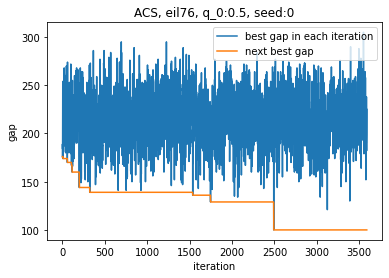

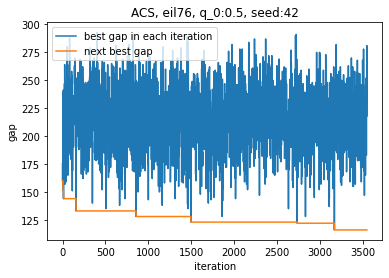

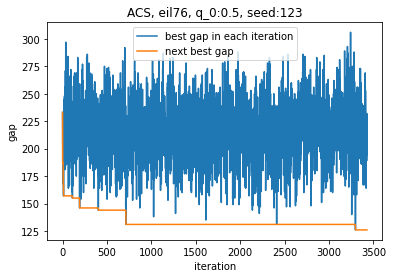

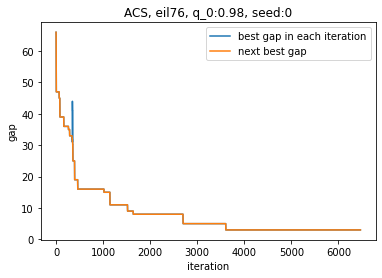

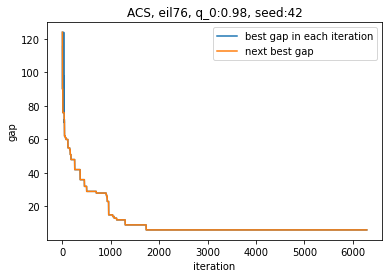

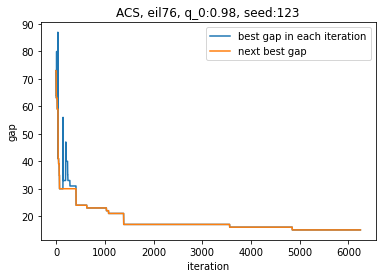

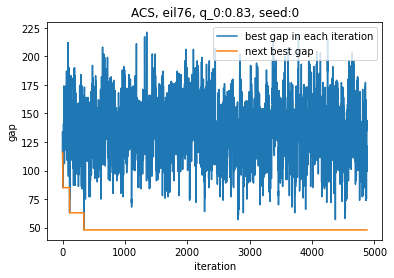

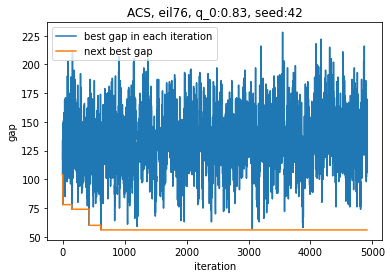

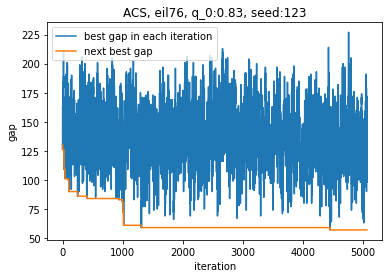

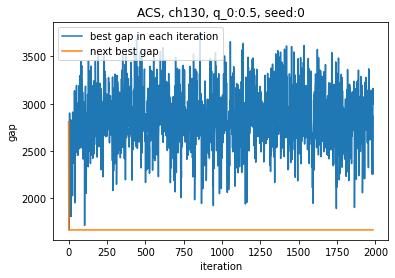

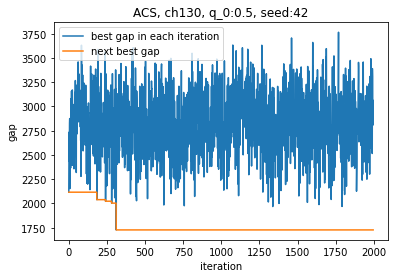

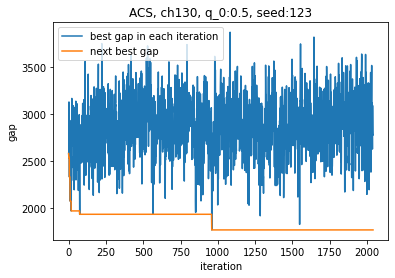

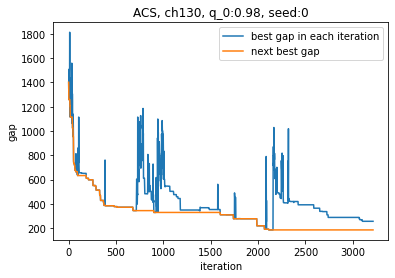

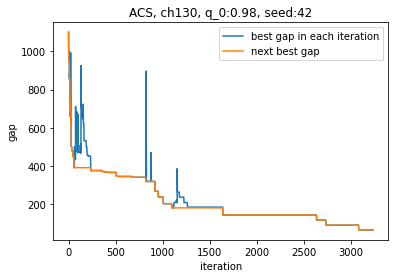

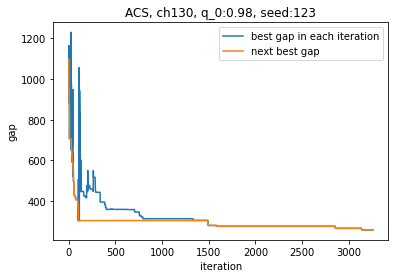

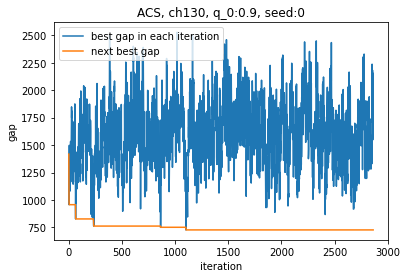

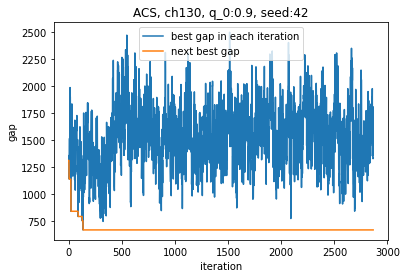

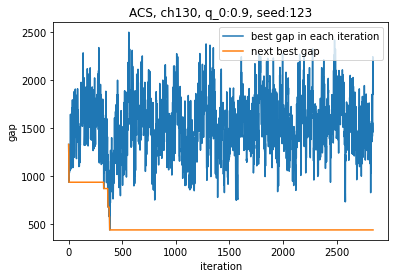

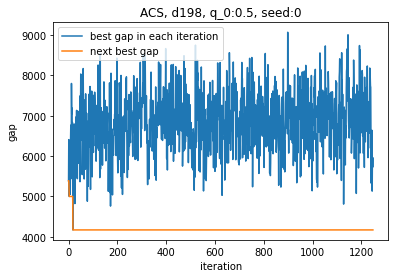

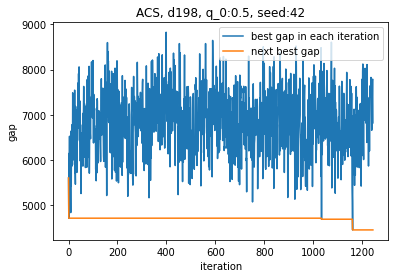

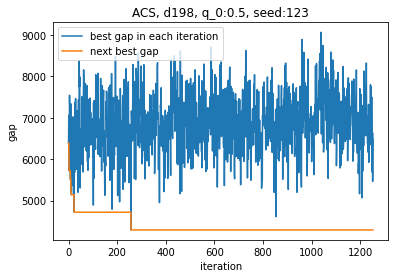

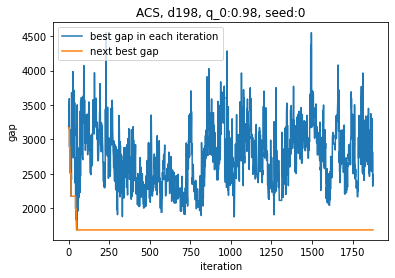

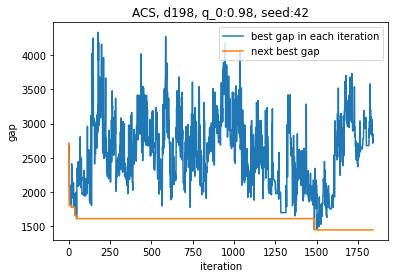

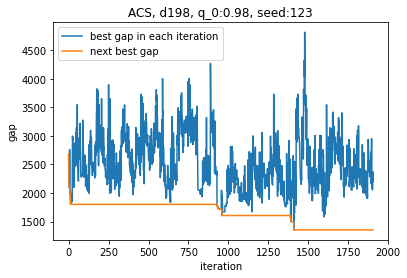

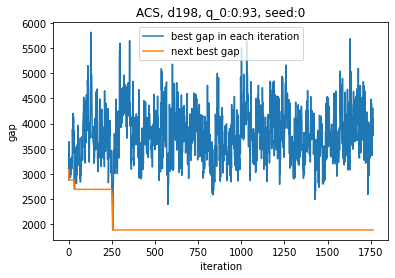

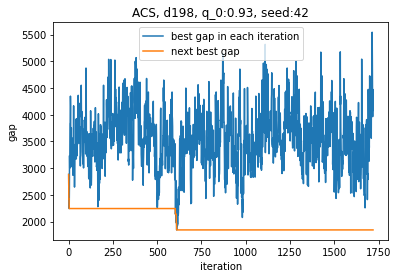

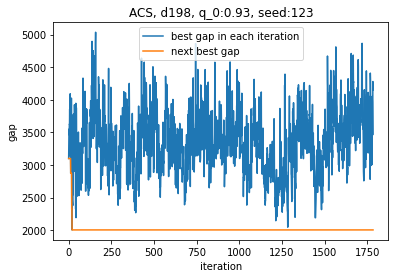

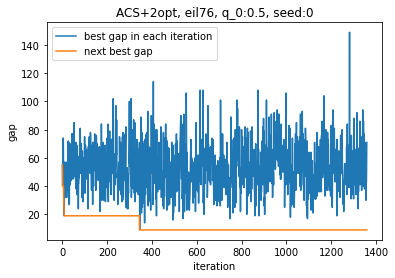

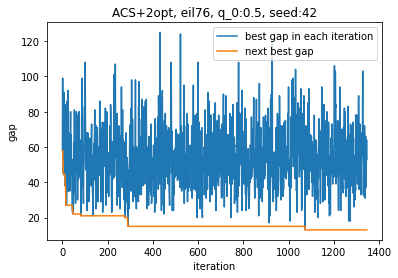

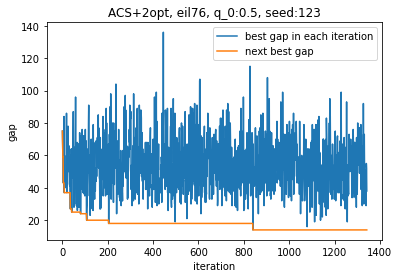

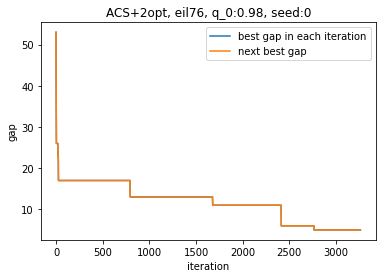

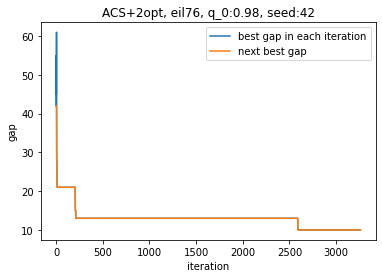

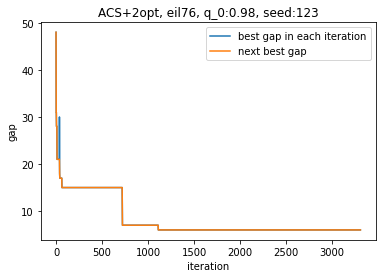

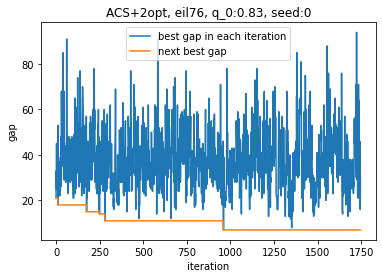

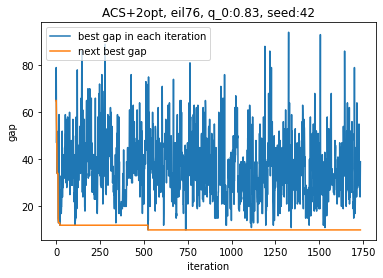

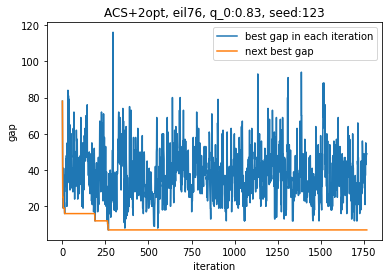

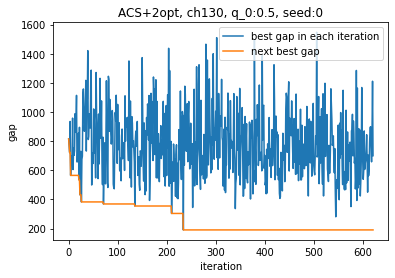

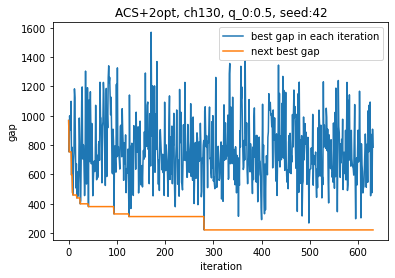

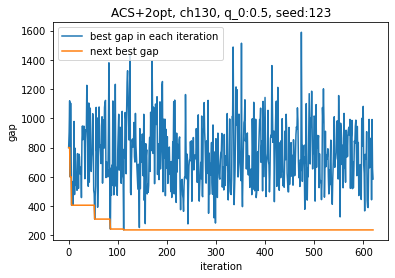

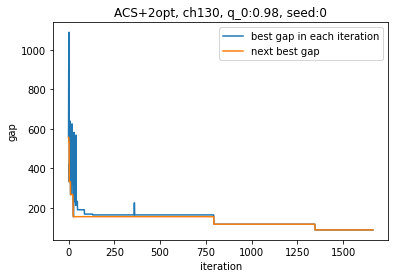

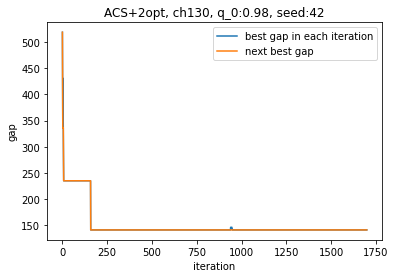

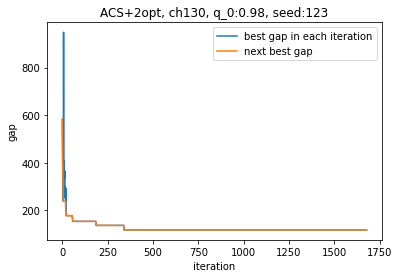

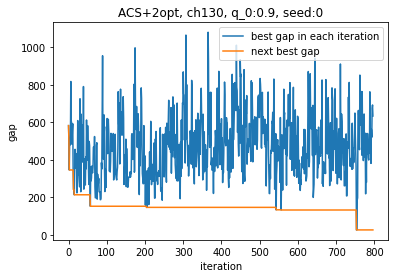

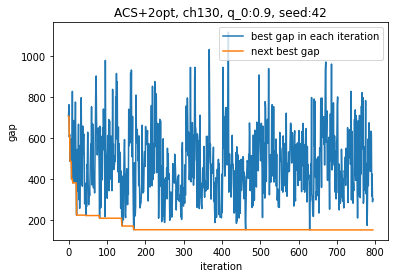

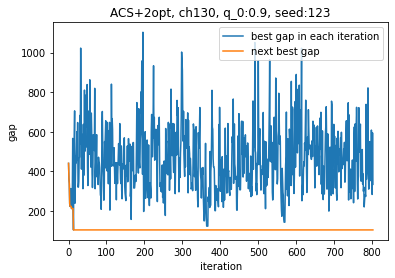

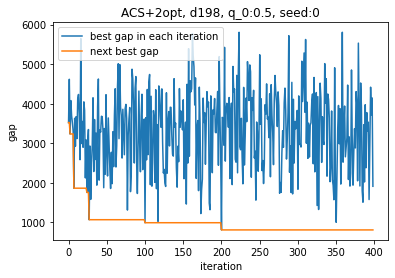

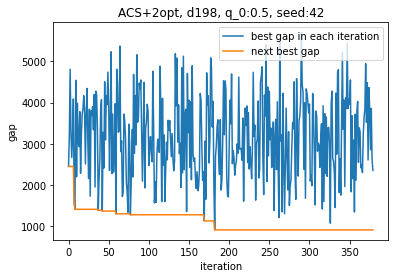

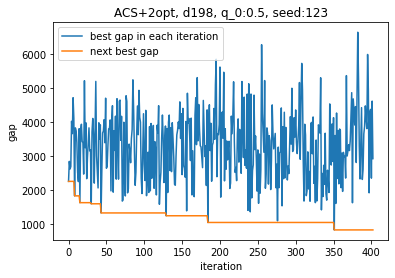

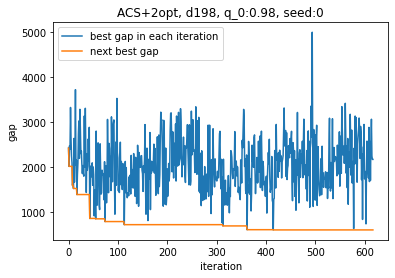

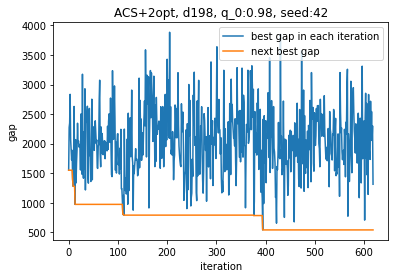

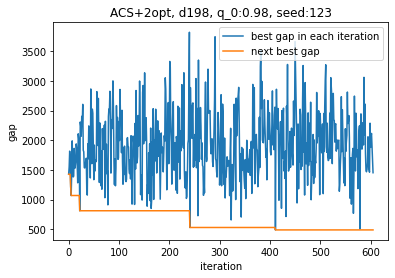

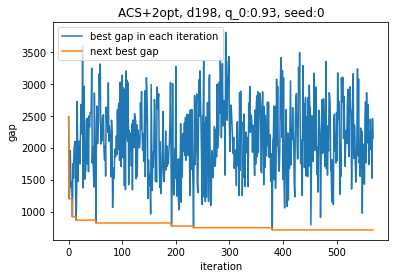

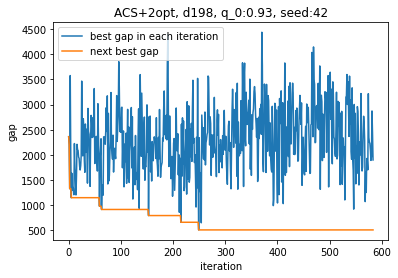

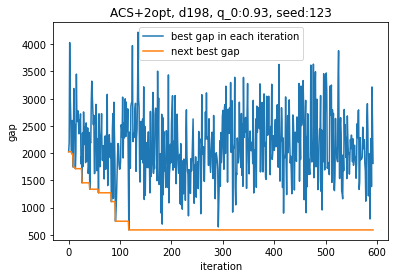

In [81]:
n = 0
for i in range(len(variants)):
  for j in range(len(instances)):
    q_0 = [0.5, 0.98, round((1 - 13/instances[j].nPoints),2)]
    for k in range(len(q_0)):
      for l in range(len(seeds)):
        plt.plot(gap_list[n], label = 'best gap in each iteration')
        plt.plot(gap_list_best_all[n], label = 'next best gap')
        plt.xlabel('iteration')
        plt.ylabel('gap')
        plt.title(variants[i] + ', '+ instances[j].name+ ', ' +'q_0:'+ str(q_0[k]) + ', ' + 'seed:'+ str(seeds[l]))
        n += 1 

        plt.legend()
        plt.show()  